Chapter 7

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
import seaborn as sns
import patsy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import itertools
from sklearn.feature_selection import SequentialFeatureSelector as SFS

In [3]:
wage = sm.datasets.get_rdataset("Wage", "ISLR").data

In [4]:
wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
rownames,,,,,,,,,,,
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [6]:
X = wage[['age']]
y = wage['wage']

In [7]:
degrees = list(range(1, 11))
cv_errors = []

# Use 10-fold CV for efficiency (LOOCV would be very slow)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for d in degrees:
    model = make_pipeline(PolynomialFeatures(degree=d, include_bias=False), LinearRegression())
    scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    cv_errors.append(-scores.mean())

optimal_degree = np.argmin(cv_errors) + 1
print(f"Optimal polynomial degree: {optimal_degree}")

Optimal polynomial degree: 8


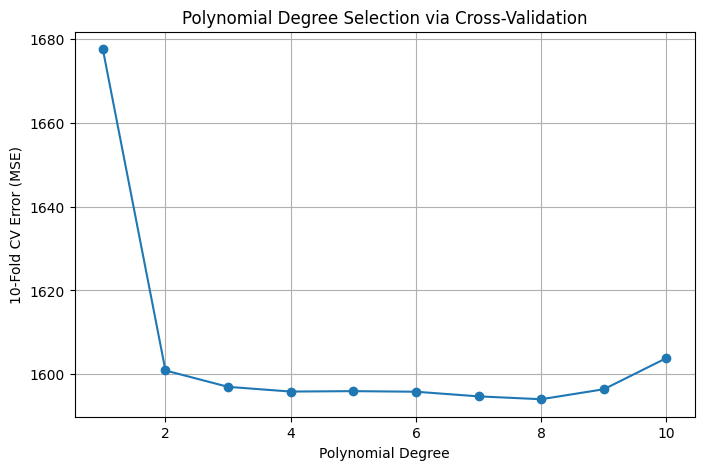

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(degrees, cv_errors, marker='o')
plt.xlabel("Polynomial Degree")
plt.ylabel("10-Fold CV Error (MSE)")
plt.title("Polynomial Degree Selection via Cross-Validation")
plt.grid(True)
plt.show()

In [9]:
poly = make_pipeline(PolynomialFeatures(optimal_degree, include_bias=False), LinearRegression())
poly.fit(X, y)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=np.int64(8), include_bias=False)),
                ('linearregression', LinearRegression())])

In [10]:
age_grid = np.linspace(X.min(), X.max(), 100)
y_pred = poly.predict(age_grid)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


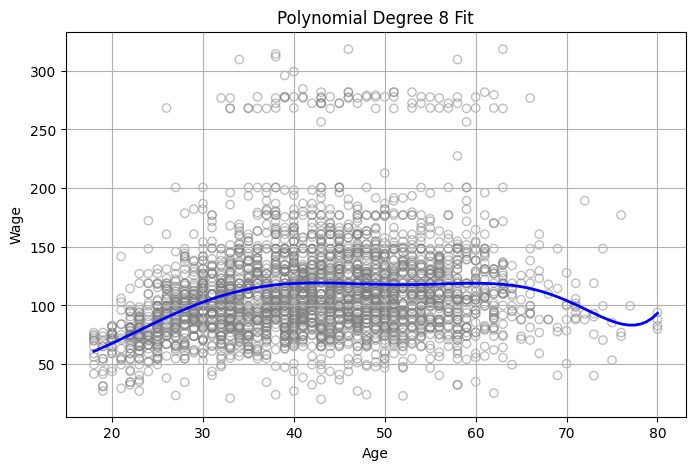

In [11]:
plt.figure(figsize=(8, 5))
plt.scatter(X, y, facecolors='none', edgecolors='gray', alpha=0.5)
plt.plot(age_grid, y_pred, color='blue', linewidth=2)
plt.xlabel("Age")
plt.ylabel("Wage")
plt.title(f"Polynomial Degree {optimal_degree} Fit")
plt.grid(True)
plt.show()

In [12]:
step_cv_errors = []
cut_range = range(2, 11)

for k in cut_range:
    # Discretize age into bins (step function)
    wage['age_bin'] = pd.cut(wage['age'], bins=k)
    # Create dummy variables
    X_step = pd.get_dummies(wage['age_bin'], drop_first=True)
    y = wage['wage']
    model = LinearRegression()
    scores = cross_val_score(model, X_step, y, cv=kf, scoring='neg_mean_squared_error')
    step_cv_errors.append(-scores.mean())

optimal_cuts = cut_range[np.argmin(step_cv_errors)]
print(f"Optimal number of cuts for step function: {optimal_cuts}")

Optimal number of cuts for step function: 8


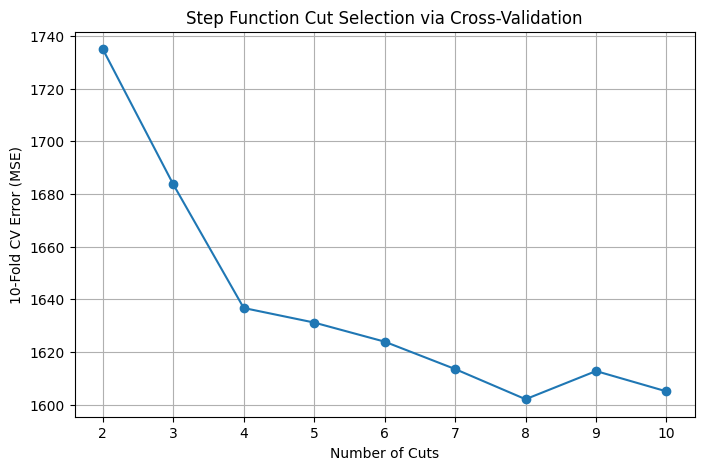

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(cut_range, step_cv_errors, marker='o')
plt.xlabel("Number of Cuts")
plt.ylabel("10-Fold CV Error (MSE)")
plt.title("Step Function Cut Selection via Cross-Validation")
plt.grid(True)
plt.show()

In [14]:
wage['age_bin'] = pd.cut(wage['age'], bins=optimal_cuts)
X_step = pd.get_dummies(wage['age_bin'], drop_first=True)
model = LinearRegression()
model.fit(X_step, y)

LinearRegression()

In [15]:
bin_centers = wage['age_bin'].apply(lambda x: x.mid).values
predicted = model.predict(X_step)

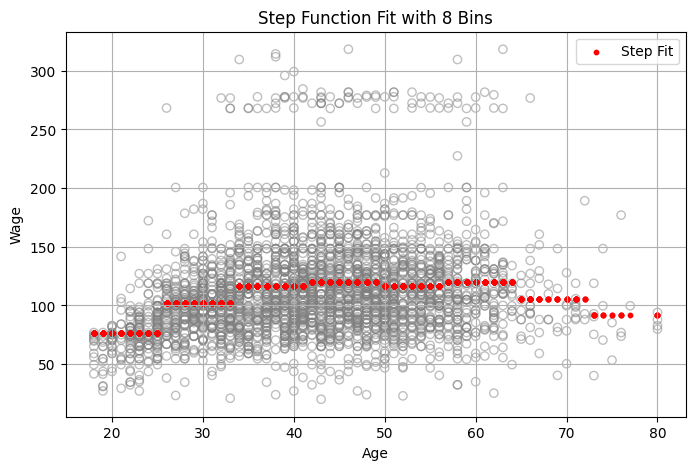

In [16]:
plt.figure(figsize=(8, 5))
plt.scatter(wage['age'], y, facecolors='none', edgecolors='gray', alpha=0.5)
plt.scatter(wage['age'], predicted, color='red', s=10, label='Step Fit')
plt.xlabel("Age")
plt.ylabel("Wage")
plt.title(f"Step Function Fit with {optimal_cuts} Bins")
plt.grid(True)
plt.legend()
plt.show()

In [45]:
college = sm.datasets.get_rdataset("College", "ISLR").data
college['Private'] = college['Private'].astype('category')
college = pd.get_dummies(college, drop_first=True)

In [46]:
college.head()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_Yes
rownames,,,,,,,,,,,,,,,,,,
Abilene Christian University,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,True
Adelphi University,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,True
Adrian College,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,True
Agnes Scott College,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,True
Alaska Pacific University,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,True


In [37]:
X = college.drop(columns="Outstate")
X = pd.get_dummies(X, drop_first=True)
y = college["Outstate"]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [53]:
lr = LinearRegression()
sfs = SFS(lr, n_features_to_select=10, direction="forward", scoring='neg_mean_squared_error')
sfs.fit(X_train, y_train)


SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=10,
                          scoring='neg_mean_squared_error')

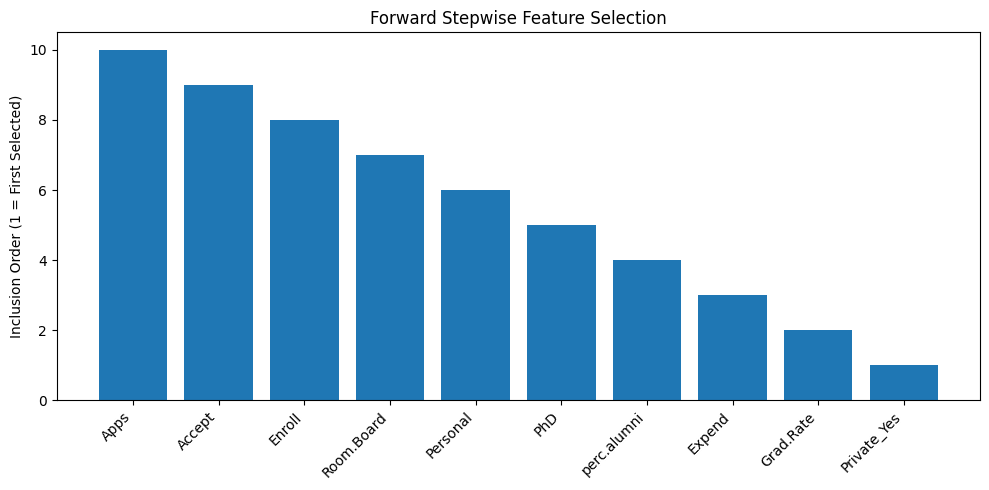

In [62]:
selected_mask = sfs.get_support()
selected_features = X_train.columns[selected_mask]

# Order features by appearance (if available from estimator history)
if hasattr(sfs, 'feature_names_in_'):
    all_features = list(X_train.columns)
    selected_idx = [i for i, x in enumerate(sfs.get_support()) if x]
    ranked_features = [all_features[i] for i in selected_idx]
else:
    ranked_features = list(selected_features)

# Plot feature inclusion order
plt.figure(figsize=(10, 5))
plt.bar(range(len(ranked_features)), np.arange(len(ranked_features), 0, -1))
plt.xticks(ticks=range(len(ranked_features)), labels=ranked_features, rotation=45, ha='right')
plt.ylabel("Inclusion Order (1 = First Selected)")
plt.title("Forward Stepwise Feature Selection")
plt.tight_layout()
plt.show()

In [63]:
%pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 4.3 MB/s eta 0:00:00


In [70]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [72]:
X_train_selected = pd.get_dummies(X_train_selected, drop_first=True)
X_test_selected = pd.get_dummies(X_test_selected, drop_first=True)

In [66]:
from pygam import LinearGAM, s,f,l

In [74]:
# Convert selected features to numeric, coercing errors to NaN
X_train_selected = X_train_selected.apply(pd.to_numeric, errors='coerce')
X_test_selected = X_test_selected.apply(pd.to_numeric, errors='coerce')

gam = LinearGAM().fit(X_train_selected, y_train)

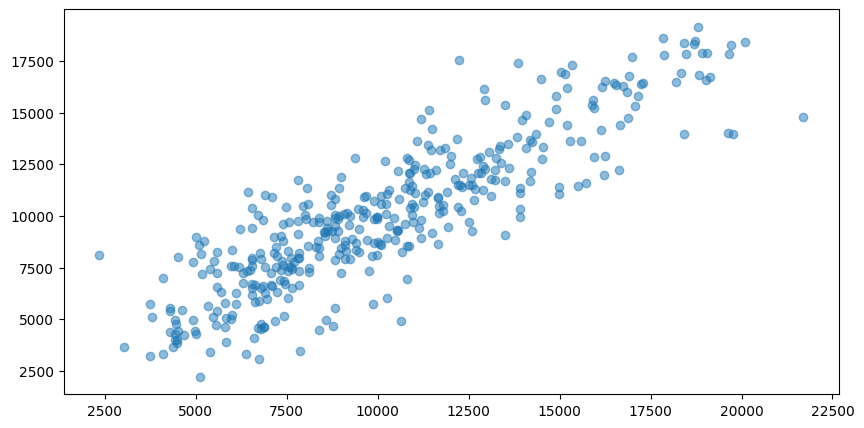

In [75]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, gam.predict(X_test_selected), alpha=0.5)

In [76]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      79.623
Link Function:                     IdentityLink Log Likelihood:                                 -6143.2761
Number of Samples:                          388 AIC:                                            12447.7983
                                                AICc:                                           12490.7564
                                                GCV:                                          4694738.5874
                                                Scale:                                        3000373.2597
                                                Pseudo R-Squared:                                    0.861
Feature Function                  Lam

/tmp/ipython-input-76-3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [77]:
test_mse = mean_squared_error(y_test, gam.predict(X_test_selected))
test_r2 = r2_score(y_test, gam.predict(X_test_selected))

In [78]:
print(f"Test MSE: {test_mse}")
print(f"Test R^2: {test_r2}")

Test MSE: 3593088.0172289177
Test R^2: 0.7620380526127262
